<a href="https://colab.research.google.com/github/jgbrasier/protein-classification/blob/main/ProtClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep sequence models for protein classification

In [25]:
import io
import pandas as pd
import matplotlib.pyplot as plt

## Downloading data
download and save to local drive: https://www.kaggle.com/shahir/protein-data-set

### Uploading data to Colab

Click on "chose files" upload both:
 - pdb_data_seq.csv
 - pdb_data_no_dups.csv

In [2]:
from google.colab import files
uploaded = files.upload()

Saving pdb_data_seq.csv to pdb_data_seq.csv


In [3]:
uploaded2 = files.upload()

Saving pdb_data_no_dups.csv to pdb_data_no_dups.csv


In [4]:
# convert data to pandas dataframe
seq = pd.read_csv(io.BytesIO(uploaded['pdb_data_seq.csv']))
nodups = pd.read_csv(io.BytesIO(uploaded2['pdb_data_no_dups.csv']))

## Data cleaning and preparation

In [45]:
# merge both data frames on structure id, remove duplicates
df = nodups.merge(seq, how='inner', on='structureId').drop_duplicates(['structureId'])
# remove NaN values
df = df.dropna()
# keep only proteins and reset indexes
df = df[df['macromoleculeType_x'] == 'Protein'].reset_index()
# keep structureId, classification, residueCount_x, sequence
df = df[['structureId', 'classification', 'residueCount_x', 'sequence']]
df.columns = ['structureId', 'classification', 'residueCount', 'sequence']
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 60757


In [32]:
df.head()

,index,structureId,classification,residueCount,sequence
0,0,1914,ALU DOMAIN,232,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...
1,1,1A04,SIGNAL TRANSDUCTION PROTEIN,430,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...
2,2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),650,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
3,3,1A2B,ONCOGENE PROTEIN,182,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...
4,4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),206,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...


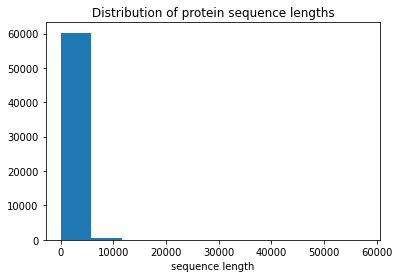

In [46]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [49]:
# remove proteins with lengths > 5000 to save compute time on LSTM models
df = df[df['residueCount'] < 5000].reset_index()
print("Total number of unique proteins:", len(df))
print("Total number of unique classification labels:", len(df.classification.unique()))

Total number of unique proteins: 60095
Total number of unique classification labels: 2149


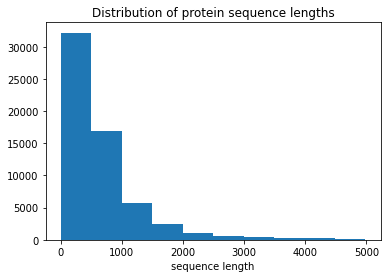

In [48]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

2149